### STEP 2: Introducing and Loading the Dataset -- Esther

#### Installing and importing libraries

In [1]:
%pip install scipy
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install seaborn
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import NearMiss
import matplotlib.patches as mpatches
import time

In [3]:
# Load in the dataset from a csv
#csv = pd.read_csv('data/creditcard.csv')
csv = pd.read_csv("/Users/riajain/Downloads/creditcard.csv")

# Convert the data to a pandas dataframe
cc_data = pd.DataFrame(csv)

# Get the shape of the dataframe: (rows, columns)
cc_data.shape

(284807, 31)

In [4]:
# See the first five rows of the dataframe:
cc_data.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
40826,40418.0,-1.035609,1.542912,0.637134,0.547050,0.511495,-0.319912,0.808113,-0.263696,-0.127401,...,0.076678,0.387602,-0.181921,-0.437136,-0.030114,-0.309839,-0.006461,0.301789,7.81,0
101894,67973.0,-1.089276,-0.001547,0.781297,-0.962553,0.035118,0.291487,-0.455825,0.563647,0.785614,...,0.248367,0.938419,-0.149674,-0.946807,0.167827,-0.388029,0.020399,0.039401,23.95,0
25615,33688.0,1.449760,-1.086815,0.939533,-1.387636,-1.860805,-0.599611,-1.338965,-0.022024,-1.908196,...,0.005017,0.415406,0.012767,0.534471,0.293291,-0.133644,0.050938,0.018934,7.90,0
230014,146148.0,-0.824533,0.498094,1.553030,2.514590,-0.215905,0.942234,-0.572247,0.047823,-0.599037,...,0.011410,0.151330,0.010503,0.702266,-1.767731,2.340788,-0.452543,0.285267,63.25,0
30054,35754.0,1.251524,-0.568358,0.021687,-0.704008,-0.690924,-0.167623,-0.792751,0.165397,-0.843836,...,0.118773,0.136699,-0.048256,-0.403626,0.261961,-0.251540,0.028354,0.033856,49.90,0


### STEP 3: Exploratory data analysis -- Ria

In [6]:
print('No Fraud', round(cc_data['Class'].value_counts()[0]/len(cc_data) * 100,2), '% of the dataset')
print('Frauds', round(cc_data['Class'].value_counts()[1]/len(cc_data) * 100,2), '% of the dataset')

No Fraud 99.83 % of the dataset
Frauds 0.17 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

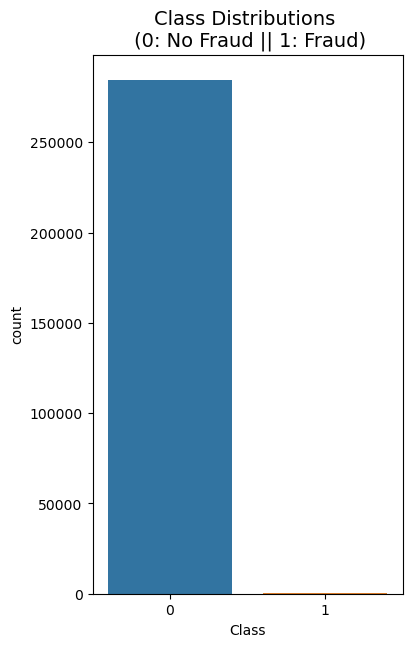

In [10]:
# Create a bar chart that visualizes the imbalance between fraudulent and non-fraudulent data

plt.figure(figsize = (4, 7))
sns.countplot(data=cc_data, x='Class')
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

## STEP 4: Data Cleaning and Initializing The Model with sklearn (no undersampling) -- MILLER

### Data splitting

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X_train, X_test, Y_train, Y_test = train_test_split(df_no_dup['text'], 
                                                    df_no_dup['target'],
                                                    test_size=0.3,
                                                    random_state=0)

### Data preparation and data cleaning

In [ ]:
def text_clean(text, method, rm_stop):
    text = re.sub(r"\n","",text)   #remove line breaks
    text = text.lower() #convert to lowercase 
    text = re.sub(r"\d+","",text)   #remove digits and currencies 
    text = re.sub(r'[\$\d+\d+\$]', "", text)      
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)   #remove dates 
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'[^\x00-\x7f]',r' ',text)   #remove non-ascii
    text = re.sub(r'[^\w\s]','',text)   #remove punctuation
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)   #remove hyperlinks
    
    #remove stop words 
    if rm_stop == True:
        filtered_tokens = [word for word in word_tokenize(text) if not word in set(stopwords.words('english'))]
        text = " ".join(filtered_tokens)
        
    #lemmatization: typically preferred over stemming
    if method == 'L':
        lemmer = WordNetLemmatizer()
        lemm_tokens = [lemmer.lemmatize(word) for word in word_tokenize(text)]
        return " ".join(lemm_tokens)
    
    #stemming 
    if method == 'S':
        porter = PorterStemmer()
        stem_tokens = [porter.stem(word) for word in word_tokenize(text)]
        return " ".join(stem_tokens)
    
    return text

In [ ]:
#preprocessed data: Lemm + stopword removal 
preprocessed_text_1 = [text_clean(text, 'L', True) for text in X_train]
#preprocessed_text_1[0:10]

#preprocessed data: Lemm + no stopword removal 
preprocessed_text_2 = [text_clean(text, 'L', False) for text in X_train]
#preprocessed_text_2[0:10]

#preprocessed data: Stem + stopword removal 
preprocessed_text_3 = [text_clean(text, 'S', True) for text in X_train]
#preprocessed_text_3[0:10]

#preprocessed data: Stem + no stopword removal 
preprocessed_text_4 = [text_clean(text, 'S', False) for text in X_train]
#preprocessed_text_4[0:10]

### WE'RE USING RANDOM FORESTS AS OUR CLASSIFIER

In [ ]:
def transform_model_data_w_count_vectorizer(preprocessed_text, Y_train,  X_test, Y_test):
    #vectorize dataset 
    vectorizer = CountVectorizer()
    vectorized_data = vectorizer.fit_transform(preprocessed_text)

    #define model
    model = MultinomialNB(alpha=0.1)
    model.fit(vectorized_data, Y_train)

    #evaluate model
    predictions = model.predict(vectorizer.transform(X_test))
    accuracy = accuracy_score( Y_test, predictions)
    balanced_accuracy = balanced_accuracy_score(Y_test, predictions)
    precision = precision_score(Y_test, predictions)

    print("Accuracy:",round(100*accuracy,2),'%')
    print("Balanced accuracy:",round(100*balanced_accuracy,2),'%')
    print("Precision:", round(100*precision,2),'%')
    return predictions

In [ ]:
def transform_model_data_w_tfidf_vectorizer(preprocessed_text, Y_train,  X_test, Y_test):
    #vectorize dataset 
    tfidf = TfidfVectorizer() 
    vectorized_data = tfidf.fit_transform(preprocessed_text)

    #define model
    model = MultinomialNB(alpha=0.1)
    model.fit(vectorized_data, Y_train)
 
    #evaluate model
    predictions = model.predict(tfidf.transform(X_test))

    accuracy = accuracy_score( Y_test, predictions)
    balanced_accuracy = balanced_accuracy_score(Y_test, predictions)
    precision = precision_score(Y_test, predictions)

    print("Accuracy:",round(100*accuracy,2),'%')
    print("Balanced accuracy:",round(100*balanced_accuracy,2),'%')
    print("Precision:", round(100*precision,2),'%')
    return predictions

In [ ]:
#vectorize, model, and evaluate model using CountVectorizer

#Lemm + stopword removal 
print("Lemm + stopword removal + CountVectorizer") 
transform_model_data_w_count_vectorizer(preprocessed_text_1, Y_train,  X_test, Y_test)

#Lemm + no stopword removal 
print("\nLemm + no stopword removal + CountVectorizer") 
transform_model_data_w_count_vectorizer(preprocessed_text_2, Y_train,  X_test, Y_test)

#Stem + stopword removal 
print("\nStem + stopword removal + CountVectorizer") 
transform_model_data_w_count_vectorizer(preprocessed_text_3, Y_train,  X_test, Y_test)

#Stem + no stopword removal 
print("\nStem + no stopword removal + CountVectorizer") 
transform_model_data_w_count_vectorizer(preprocessed_text_4, Y_train,  X_test, Y_test)

In [ ]:
#vectorize, model, and evaluate model using TfidfVectorizer

#Lemm + stopword removal 
print("Lemm + stopword removal + TfidfVectorizer") 
transform_model_data_w_tfidf_vectorizer(preprocessed_text_1, Y_train,  X_test, Y_test)

#Lemm + no stopword removal 
print("\nLemm + no stopword removal + TfidfVectorizer") 
transform_model_data_w_tfidf_vectorizer(preprocessed_text_2, Y_train,  X_test, Y_test)

#Stem + stopword removal 
print("\nStem + stopword removal + TfidfVectorizer") 
transform_model_data_w_tfidf_vectorizer(preprocessed_text_3, Y_train,  X_test, Y_test)

#Stem + no stopword removal 
print("\nStem + no stopword removal + TfidfVectorizer") 
transform_model_data_w_tfidf_vectorizer(preprocessed_text_4, Y_train,  X_test, Y_test)

In [ ]:
predictions = transform_model_data_w_tfidf_vectorizer(preprocessed_text_4, Y_train,  X_test, Y_test)

In [ ]:
#compute the confusion matrix.
cm = confusion_matrix(Y_test, predictions)

 #Plot the confusion matrix.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

## STEP 4b: Evaluation with Performance Metrics -- Alyssa

## STEP 5: Undersampling Techniques -- Esther (just write the general blurb for this)

### Random Downsampling -- Esther

In [ ]:
fraud_df = cc_data.loc[cc_data['Class'] == 1]
non_fraud_df = cc_data.loc[cc_data['Class'] == 0][:492]
display(fraud_df.head())
display(non_fraud_df.head())

### Spam and Ham Stuff


In [ ]:
colors = ["#0101DF", "#DF0101"]

sns.countplot(data=df, x='Class', palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

In [ ]:
print('Top 5 common duplicate texts are:')
data[data.duplicates == 1].pivot_table(index='text', values='target', aggfunc='count').sort_values(by='target', ascending=False).head(5)

In [ ]:
#check for missing data
print("Missing data in each column:\n" + str(data.isnull().sum()))

In [ ]:
data['target'].value_counts()

In [ ]:
# Explore distribution of dataset 

# count plot on single categorical variable
ax = sns.countplot(x = data['classification'], palette = 'rocket')

#add data labels
ax.bar_label(ax.containers[0])

# add plot title
plt.title("Observations by Classification Type")

# show plot
plt.show()

Note: Distribution of dataset indicates imbalanced data.

In [ ]:
# Dropping all duplicate texts based off of results of EDA
df_no_dup = data.drop_duplicates(subset=['text'], keep='first')

In [ ]:
# Explore distribution of dataset 

# count plot on single categorical variable
ax = sns.countplot(x = df_no_dup['classification'], palette = 'rocket')

#add data labels
ax.bar_label(ax.containers[0])

# add plot title
plt.title("Observations by Classification Type")

# show plot
plt.show()

###  Near Miss Undersampling -- Ria

In [16]:
#Splitting the data into features and labels 
X = cc_data.iloc[:,:30]
y = cc_data.iloc[:, 30]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=45)

near_miss = NearMiss()
X_resample, y_resample = near_miss.fit_resample(X_train,y_train)

In [17]:
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
print("After Undersampling, counts of label '1': {}".format(sum(y_resample == 1))) 
print("After Undersampling, counts of label '0': {}".format(sum(y_resample == 0))) 

Before Undersampling, counts of label '1': 377
Before Undersampling, counts of label '0': 227468 

After Undersampling, counts of label '1': 377
After Undersampling, counts of label '0': 377


In [18]:
# Using sklearn's Logistic Regression model class -> most useful for binary classification 
model = LogisticRegression(max_iter = 1000)

# Fitting the training data
model.fit(X_train, y_train)

score = model.score(X_val, y_val)
print(score)

0.9991397773954567


### Tomek Link Undersampling -- Miller